In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [14]:
print(env.action_space.n)
#print(np.random.choice(range(2),p=np.array([1.0,0.0])))

2


In [55]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    
    def run_episode():
        observations, rewards = [], []
        observation = env.reset()
        while True:
            action = np.random.choice(range(env.action_space.n),p=policy(observation))#np.argmax(policy(observation))
            next_observation, reward, done, _ = env.step(action)
            
            observations.append(observation)
            rewards.append(reward)
            
            observation = next_observation
            
            if done:
                break
        
        return observations, rewards
    
    def calculate_return(t, rewards):
        T = len(rewards) 
        return np.sum([discount_factor**(k-t)*rewards[k] for k in range(t,T)])
    
    def print_observation(observation):
        score, dealer_score, usable_ace = observation
        print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
              score, usable_ace, dealer_score))
    
    def print_transitions(observations, rewards):
        for obs, r in zip(observations, rewards):
            print_observation(obs)
            print("Reward: {}\n".format(r))
            
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for eps in range(num_episodes):
        #print("Episode {}".format(eps))
        # Generate episode
        observations, rewards = run_episode()
        #print_transitions(observations, rewards)
        
        # Update V
        visited = []
        for t, obs in enumerate(observations):
            #print("t = ",t)
            if obs not in visited:
                visited.append(obs)
                #print("Not visited: ")
                #print_observation(obs)
                G = calculate_return(t, rewards)
                #print("Return: ",G)
                returns_sum[obs] += G
                returns_count[obs] += 1
                V[obs] = returns_sum[obs]/returns_count[obs]#np.average(returns_sum[obs])
        #print("\n")
    
    return V    

In [56]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array([1.0, 0.0]) if score >= 20 else np.array([0.0, 1.0])

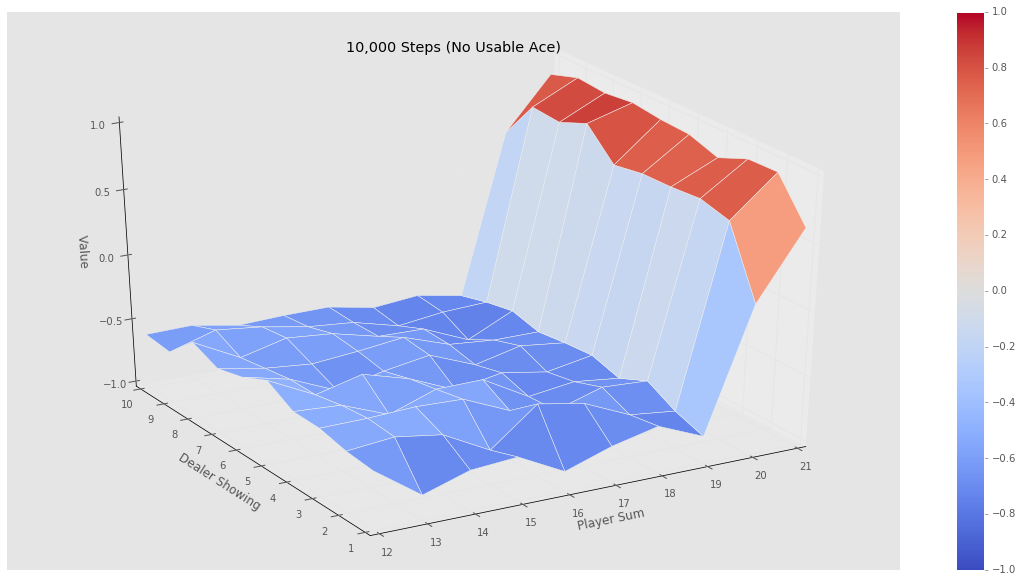

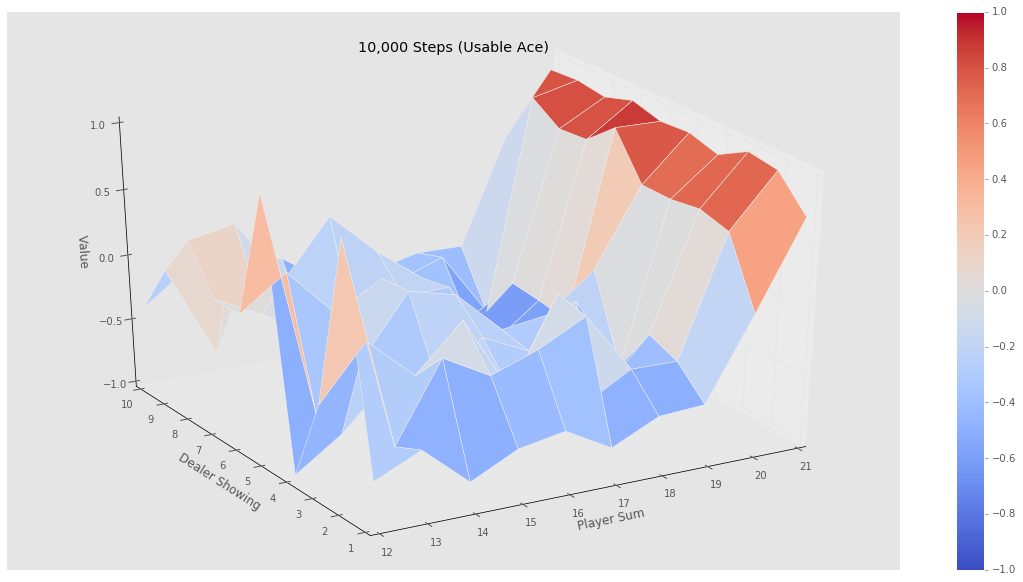

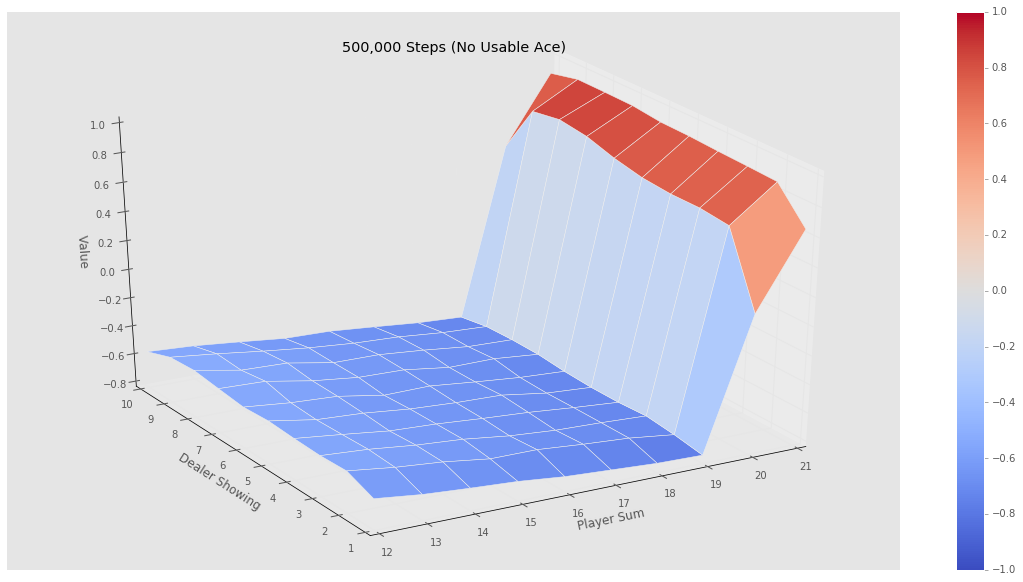

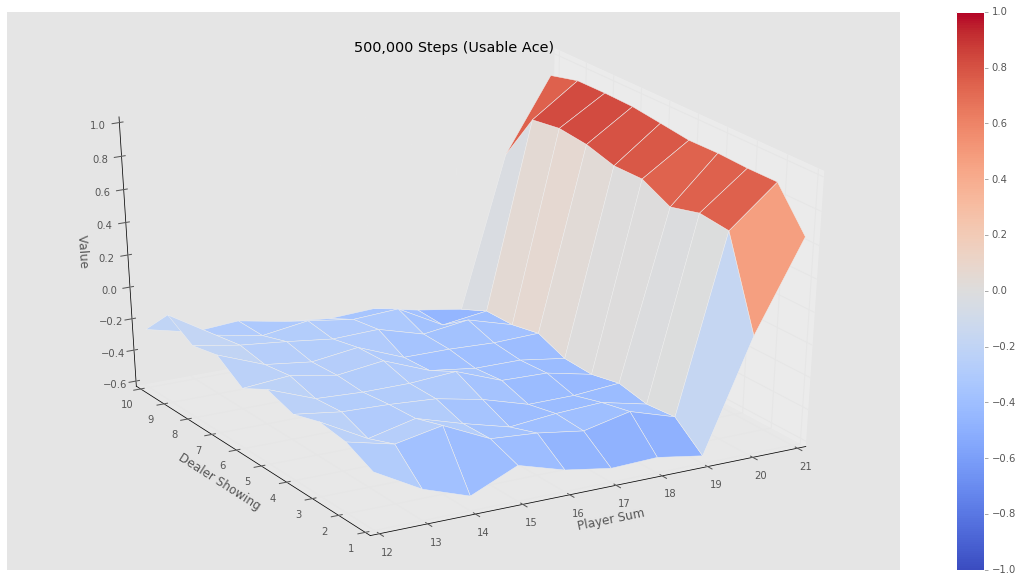

In [58]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")